In [ ]:
!unzip archive\ \(5\).zip

Archive:  archive (5).zip
  inflating: KaggleV2-May-2016.csv   


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import lmplot, stripplot

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

from time import time
from joblib import dump
from datetime import datetime
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
sns.set_style("whitegrid")


<h2> Read in Data </h3>

<ul>
    <li>Read the data in from the CSV </li>
    <li> Shuffle the data. This removes any ordering that may interfere with us later</li>
    <li> We have edited the dataframe so reset the index </li>
</ul>

In [ ]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("KaggleV2-May-2016.csv")

# Shuffle the dataset
df = df.sample(frac=1, random_state=123)
df.reset_index(drop=True, inplace=True)

<h3> Examine the data </h3>
<h4> Datatypes </h4>
View the datatypes and see if anything looks fishy. <br>
Gender, ScheduledDay, AppoinmentDat, Neighbourhood and No-Show are objects. This makes sense as they are likley of type String.

In [ ]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

## Remove Invalid Data

The min age is -1. This is not possible.

In [ ]:
print(f"Min Age: { min(df['Age'].unique()) }. Max Age: { max(df['Age'].unique()) }")

Min Age: -1. Max Age: 115


Let's remove any entery with an age of less than 0 or greater than 100.

In [ ]:
df = df[(df['Age'] >= 0) & (df['Age'] <= 100)]

Let's take a look to see if there are any NaNs or outliers in the other columns.

In [ ]:
print(f"Min: { min(df['Gender'].unique()) }. Max: { max(df['Gender'].unique()) }. Uniuqe Values: { df['Gender'].unique() }")
print(f"Min: { min(df['ScheduledDay'].unique()) }. Max: { max(df['ScheduledDay'].unique()) }. Uniuqe Values: { df['ScheduledDay'].unique() }")
print(f"Min: { min(df['AppointmentDay'].unique()) }. Max: { max(df['AppointmentDay'].unique()) }. Uniuqe Values: { df['AppointmentDay'].unique() }")
print(f"Min: { min(df['No-show'].unique()) }. Max: { max(df['No-show'].unique()) }. Uniuqe Values: { df['No-show'].unique() }")
print(f"Min: { min(df['Diabetes'].unique()) }. Max: { max(df['Diabetes'].unique()) }. Uniuqe Values: { df['Diabetes'].unique() }")
print(f"Min: { min(df['Alcoholism'].unique()) }. Max: { max(df['Alcoholism'].unique()) }. Uniuqe Values: { df['Alcoholism'].unique() }")
print(f"Min: { min(df['Hipertension'].unique()) }. Max: { max(df['Hipertension'].unique()) }. Uniuqe Values: { df['Hipertension'].unique() }")
print(f"Min: { min(df['Handcap'].unique()) }. Max: { max(df['Handcap'].unique()) }. Uniuqe Values: { df['Handcap'].unique() }")
print(f"Min: { min(df['Scholarship'].unique()) }. Max: { max(df['Scholarship'].unique()) }. Uniuqe Values: { df['Scholarship'].unique() }")
print(f"Min: { min(df['SMS_received'].unique()) }. Max: { max(df['SMS_received'].unique()) }. Uniuqe Values: { df['SMS_received'].unique() }")

Min: F. Max: M. Uniuqe Values: ['M' 'F']
Min: 2015-11-10T07:13:56Z. Max: 2016-06-08T20:07:23Z. Uniuqe Values: ['2016-05-13T09:51:06Z' '2016-05-11T08:05:20Z' '2016-05-20T09:07:02Z' ...
 '2016-05-17T11:42:54Z' '2016-05-13T10:40:25Z' '2016-05-12T09:30:54Z']
Min: 2016-04-29T00:00:00Z. Max: 2016-06-08T00:00:00Z. Uniuqe Values: ['2016-05-16T00:00:00Z' '2016-05-11T00:00:00Z' '2016-05-20T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-06-03T00:00:00Z' '2016-05-03T00:00:00Z'
 '2016-06-07T00:00:00Z' '2016-05-05T00:00:00Z' '2016-05-06T00:00:00Z'
 '2016-05-09T00:00:00Z' '2016-05-30T00:00:00Z' '2016-04-29T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-12T00:00:00Z' '2016-06-02T00:00:00Z'
 '2016-05-25T00:00:00Z' '2016-05-13T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-06-06T00:00:00Z' '2016-05-19T00:00:00Z' '2016-06-01T00:00:00Z'
 '2016-06-08T00:00:00Z' '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z'
 '2016-05-18T00:00:00Z' '2016-05-10T00:00:00Z' '2016-05-14T00:00:00Z']
Min: No. Max: Yes. Uniuqe Values: ['Yes' 'No'

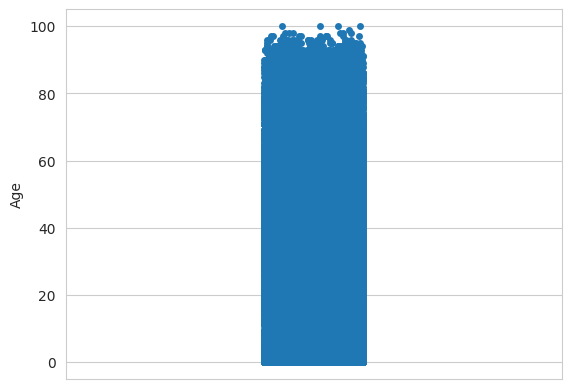

In [ ]:
sns.stripplot(data = df, y = 'Age', jitter = True)
plt.show()

# Feature Engineering

Both `ScheduledDay` and `AppointmentDay` are useless on their own but we can create some usefull features out of it. Such as day of regstering and day of appointment. Hour of registering and hour of appointment. Finally duration between booking and the appoinment.

In [ ]:
def date_to_day_of_week(date):
  if type(date) != str:
    return -1
  date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ')
  return date.weekday()

def date_to_hour(date):
  if type(date) != str:
    return -1
  date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ')
  return date.hour

def minutes_between_dates(date1, date2):
  date1 = datetime.strptime(date1, '%Y-%m-%dT%H:%M:%SZ')
  date2 = datetime.strptime(date2, '%Y-%m-%dT%H:%M:%SZ')
  return (date2 - date1).total_seconds() // 60

In [ ]:
df['RegistrationDay'] = df['ScheduledDay'].apply(date_to_day_of_week)
df['AppointmentDayofWeek'] = df['AppointmentDay'].apply(date_to_day_of_week)
df['RegistrationHour'] = df['ScheduledDay'].apply(date_to_hour)

df['MinutesToAppoinment'] = df.apply(lambda row: minutes_between_dates(row['ScheduledDay'], row['AppointmentDay']), axis=1)

### Check outliers with our new features

`RegistrationDay` being 5(Saturday) is an outlier

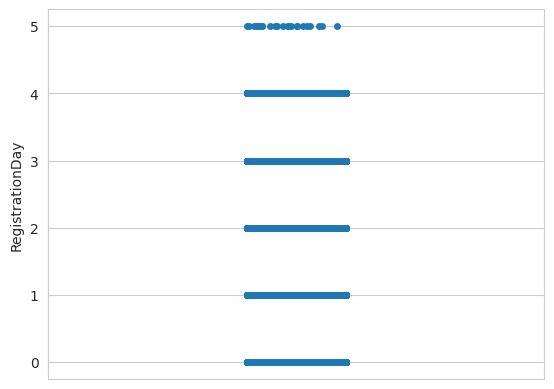

In [ ]:
sns.stripplot(data = df, y = 'RegistrationDay', jitter = True)
plt.show()
df = df[df['RegistrationDay'] < 5]

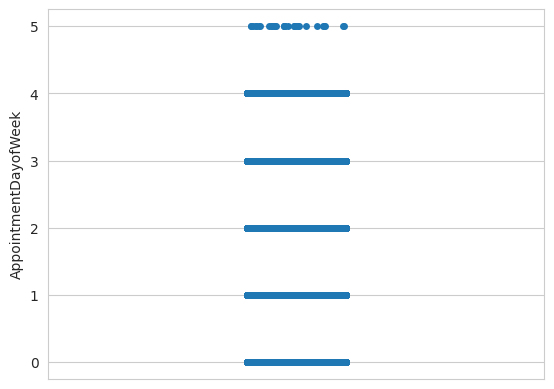

In [ ]:
sns.stripplot(data = df, y = 'AppointmentDayofWeek', jitter = True)
plt.show()
df = df[df['AppointmentDayofWeek'] < 5]

`RegistrationHour` after 20:00 has a clear drop off.

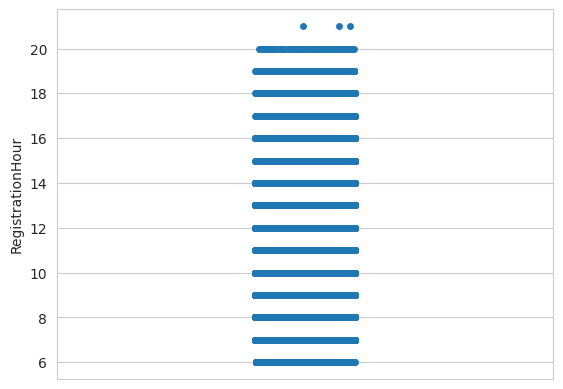

In [ ]:
sns.stripplot(data = df, y = 'RegistrationHour', jitter = True)
plt.show()
df = df[(df['RegistrationHour'] <= 20)]

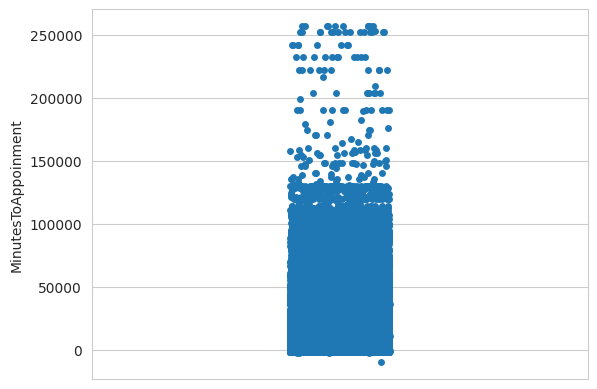

In [ ]:
sns.stripplot(data = df, y = 'MinutesToAppoinment', jitter = True)
plt.show()
df = df[(df['MinutesToAppoinment'] <=150000) & (df['MinutesToAppoinment'] > 0)]


## Encoding, Scaling and Such

In [ ]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,RegistrationDay,AppointmentDayofWeek,RegistrationHour,MinutesToAppoinment
0,8.523459e+13,5695263,M,2016-05-13T09:51:06Z,2016-05-16T00:00:00Z,73,ITARARÉ,0,1,1,0,0,0,Yes,4,0,9,3728.0
3,6.245924e+13,5619919,M,2016-04-26T08:28:06Z,2016-05-04T00:00:00Z,48,ANDORINHAS,0,0,0,0,0,1,Yes,1,2,8,11011.0
4,8.996231e+13,5764117,F,2016-06-02T09:51:32Z,2016-06-03T00:00:00Z,15,BONFIM,0,0,0,0,0,0,Yes,3,4,9,848.0
7,2.212167e+12,5689672,F,2016-05-12T08:49:27Z,2016-05-16T00:00:00Z,47,HORTO,0,0,0,0,0,0,Yes,3,0,8,5230.0
8,4.799578e+14,5728425,F,2016-05-20T16:24:30Z,2016-06-07T00:00:00Z,49,MATA DA PRAIA,0,0,0,0,0,1,No,4,1,16,24935.0


In [ ]:
df = df.drop("ScheduledDay", axis=1)
df = df.drop("AppointmentDay", axis=1)
# df = df.drop("Neighbourhood", axis=1)
df = df.drop("PatientId", axis=1)
df = df.drop("AppointmentID", axis=1)

In [ ]:
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,RegistrationDay,AppointmentDayofWeek,RegistrationHour,MinutesToAppoinment
0,M,73,ITARARÉ,0,1,1,0,0,0,Yes,4,0,9,3728.0
3,M,48,ANDORINHAS,0,0,0,0,0,1,Yes,1,2,8,11011.0
4,F,15,BONFIM,0,0,0,0,0,0,Yes,3,4,9,848.0
7,F,47,HORTO,0,0,0,0,0,0,Yes,3,0,8,5230.0
8,F,49,MATA DA PRAIA,0,0,0,0,0,1,No,4,1,16,24935.0


In [ ]:
gender_onehot = pd.get_dummies(df['Gender'])
df = pd.concat([df, gender_onehot], axis=1)
df = df.drop("Gender", axis=1)

gender_onehot = pd.get_dummies(df['Neighbourhood'])
df = pd.concat([df, gender_onehot], axis=1)
df = df.drop("Neighbourhood", axis=1)

In [ ]:
label_encoder = LabelEncoder()
df["No-show"] = label_encoder.fit_transform(df["No-show"])

In [ ]:
from sklearn.preprocessing import StandardScaler
mms = StandardScaler()
scaled_df = df
scaled_df[['Age','RegistrationDay', 'AppointmentDayofWeek', 'RegistrationHour', 'MinutesToAppoinment']] = mms.fit_transform(df[['Age','RegistrationDay', 'AppointmentDayofWeek', 'RegistrationHour', 'MinutesToAppoinment']])
# scaled_df[['Age']] = mms.fit_transform(df[['Age']])



In [ ]:
scaled_df.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,RegistrationDay,AppointmentDayofWeek,...,SANTOS REIS,SEGURANÇA DO LAR,SOLON BORGES,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,UNIVERSITÁRIO,VILA RUBIM
0,1.508594,0,1,1,0,0,0,1,1.547296,-1.365445,...,0,0,0,0,0,0,0,0,0,0
3,0.416883,0,0,0,0,0,1,1,-0.624805,0.094392,...,0,0,0,0,0,0,0,0,0,0
4,-1.024175,0,0,0,0,0,0,1,0.823262,1.554229,...,0,0,0,0,0,0,0,0,0,0
7,0.373215,0,0,0,0,0,0,1,0.823262,-1.365445,...,0,0,0,0,0,0,0,0,0,0
8,0.460552,0,0,0,0,0,1,0,1.547296,-0.635527,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = scaled_df

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.8, stratify=df["No-show"], random_state=2)
train_df, valid_df = train_test_split(train_df, train_size=0.87, stratify=train_df["No-show"], random_state=2)

In [ ]:
print("Training: ", len(train_df))
print("Validation: ", len(valid_df))
print("Test: ", len(test_df))

Training:  49961
Validation:  7466
Test:  14357


In [ ]:
features = set(train_df.columns)
features.remove('No-show')
train_X = train_df[features].copy()
validation_X = valid_df[features].copy()
test_X = test_df[features].copy()

train_y = train_df["No-show"]
validation_y = valid_df["No-show"]
test_y = test_df["No-show"]

train_y = np.asarray(train_y).astype("float64")
validation_y = np.asarray(validation_y).astype("float64")
test_y = np.asarray(test_y).astype("float64")

sm = SMOTE(random_state=42)
train_X, train_y = sm.fit_resample(train_X, train_y)

In [ ]:
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_X, train_y)
print(dummy.score(train_X, train_y))
print(dummy.score(validation_X, validation_y))

0.5
0.7147066702384142


In [ ]:
np.unique(train_y)

array([0., 1.])

In [ ]:
train_X_copy = train_X.copy()
train_y_copy = train_y.copy()

validation_X_copy = validation_X.copy()
validation_y_copy = validation_y.copy()

In [ ]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(n_estimators=100, contamination=0.01)
iso.fit(train_X_copy)
to_remove = iso.predict(train_X_copy)
indecies_to_remove = []
for i, value in enumerate(to_remove):
  if value == -1:
    indecies_to_remove.append(i)

train_X_copy = train_X_copy.drop(indecies_to_remove)
train_y_copy = np.delete(train_y_copy, indecies_to_remove)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
print(len(train_X), len(train_X_copy))
print(len(train_y), len(train_y_copy))

71418 70703
71418 70703


In [ ]:
knn = Pipeline([
    ('predictor', KNeighborsClassifier())
])
knn_param_grid = {
    "predictor__n_neighbors": [50, 100, 150]
    # "predictor__n_neighbors": [x for x in range(10, 100, 10)]

}

knn_gs = GridSearchCV(knn, knn_param_grid, scoring="accuracy", cv=10)
knn_gs.fit(train_X_copy, train_y_copy)
knn_gs.best_params_, knn_gs.best_score_

knn.set_params(**knn_gs.best_params_)
knn.fit(train_X_copy, train_y_copy)
print("Train Data: ", accuracy_score(train_y_copy, knn.predict(train_X_copy)))
print("Validation Data: ",accuracy_score(validation_y, knn.predict(validation_X)))

In [ ]:
print(knn_gs.best_params_)

{'predictor__n_neighbors': 50}


In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def build_nn():
    network = Sequential()
    network.add(Dense(16, activation="relu", input_shape=(train_X_copy.shape[1],)))
    network.add(Dense(32, activation="relu"))
    network.add(Dense(32, activation="relu"))
    network.add(Dense(16, activation="relu"))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.005), loss="binary_crossentropy", metrics=["accuracy"])
    return network

model = build_nn()

history = model.fit(
    train_X_copy,
    train_y_copy,
    epochs=100,
    validation_data=(validation_X, validation_y),
    callbacks=[early_stopping]
    )

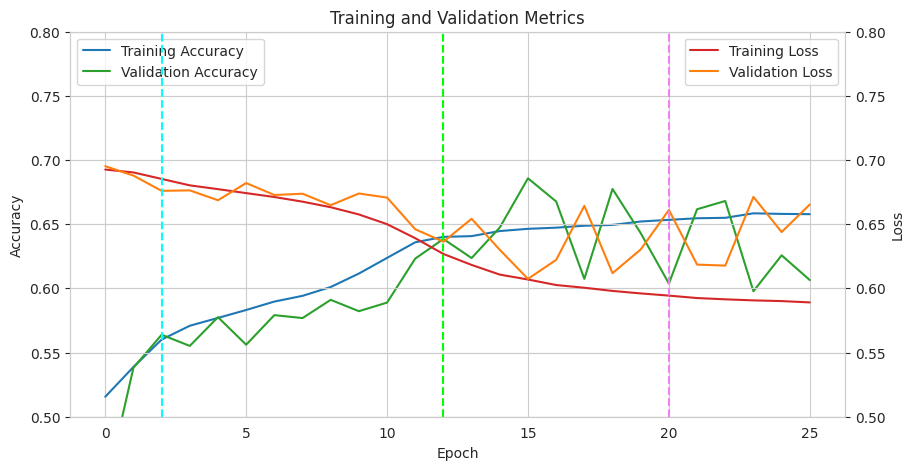

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Epoch')

# Plot the training and validation accuracy over time
ax.plot(history.history['accuracy'], label='Training Accuracy', color='tab:blue')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:green')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 0.8])  # Set y-axis limits for accuracy
ax.legend(loc='upper left')

# Add a second y-axis for the training and validation loss
ax2 = ax.twinx()
ax2.plot(history.history['loss'], label='Training Loss', color='tab:red')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
ax2.set_ylabel('Loss')
ax2.set_ylim([0.5, 0.8])  # Set y-axis limits for loss
ax2.legend(loc='upper right')

plt.axvline(x=2, color='cyan', linestyle='--')
plt.axvline(x=12, color='lime', linestyle='--')
plt.axvline(x=20, color='violet', linestyle='--')

# Display the plot
plt.title('Training and Validation Metrics')
plt.show()

449/449 [==============================] - 1s 2ms/step
[[10262     0]
 [ 4095     0]]


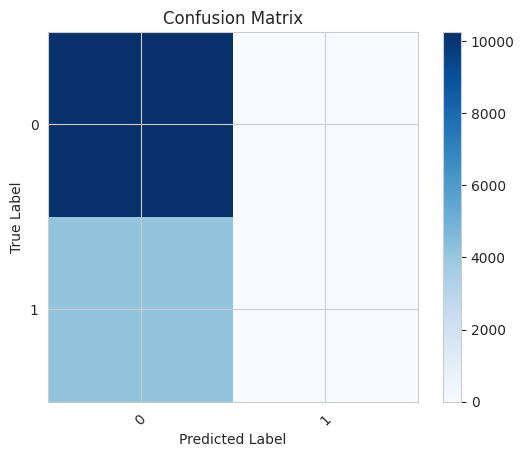

In [ ]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class labels

# Create confusion matrix
cm = confusion_matrix(test_y, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0, 1], rotation=45)
plt.yticks(tick_marks, [0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Make predictions on test set
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1) # Convert probabilities to class labels

# Compute precision, recall, and F1-score
precision = precision_score(test_y, y_pred, average='macro')
recall = recall_score(test_y, y_pred, average='macro')
f1score = f1_score(test_y, y_pred, average='macro')
acc = accuracy_score(test_y, y_pred)

# Print results
print('Accuaracy:', acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)

449/449 [==============================] - 1s 2ms/step
Accuaracy: 0.7147732813261823
Precision: 0.35738664066309117
Recall: 0.5
F1-score: 0.41683252772249074


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sfrom sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-08,hidden_layer_sizes=(8,),activation='logistic', random_state=1,batch_size='auto',shuffle=True,max_fun=15000)
clf = clf.fit(train_X_copy, train_y_copy)
print("Train Data: ", accuracy_score(train_y_copy, clf.predict(train_X_copy)))
print("Validation Data: ",accuracy_score(validation_y, clf.predict(validation_X)))

Train Data:  0.6432683195903993
Validation Data:  0.6255022769890168


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
lr = Pipeline([
    ('predictor', GaussianNB())
])
lr_param_grid = {
    'predictor__var_smoothing': np.logspace(0,-9, num=100)
}

lr_gs = GridSearchCV(lr, lr_param_grid, scoring="accuracy", cv=10)
lr_gs.fit(train_X_copy, train_y_copy)
lr_gs.best_params_, lr_gs.best_score_

lr.set_params(**lr_gs.best_params_)
lr.fit(train_X_copy, train_y_copy)
print("Train Data: ", accuracy_score(train_y_copy, lr.predict(train_X_copy)))
print("Validation Data: ",accuracy_score(validation_y, lr.predict(validation_X)))

Train Data:  0.5643042020847772
Validation Data:  0.41561746584516474


In [ ]:
lr = Pipeline([
    ('predictor', DecisionTreeClassifier())
])
lr_param_grid = {
    "predictor__max_depth": [10, 15, 20]
}

lr_gs = GridSearchCV(lr, lr_param_grid, scoring="accuracy", cv=10)
lr_gs.fit(train_X_copy, train_y_copy)
lr_gs.best_params_, lr_gs.best_score_
print(lr_gs.best_params_)
lr.set_params(**lr_gs.best_params_)
lr.fit(train_X_copy, train_y_copy)
print("Train Data: ", accuracy_score(train_y_copy, lr.predict(train_X_copy)))
print("Validation Data: ",accuracy_score(validation_y, lr.predict(validation_X)))

{'predictor__max_depth': 20}
Train Data:  0.7840119938333593
Validation Data:  0.65148673988749


In [ ]:
lr = Pipeline([
    ('predictor', SVC(cache_size=7000))
])
lr_param_grid = {}

lr_gs = GridSearchCV(lr, lr_param_grid, scoring="accuracy", cv=10)
lr_gs.fit(train_X_copy[:2500], train_y_copy[:2500])
lr_gs.best_params_, lr_gs.best_score_
print(lr_gs.best_params_)
lr.set_params(**lr_gs.best_params_)
lr.fit(train_X_copy[:2500], train_y_copy[:2500])
print("Train Data: ", accuracy_score(train_y_copy, lr.predict(train_X_copy)))
print("Validation Data: ",accuracy_score(validation_y, lr.predict(validation_X)))

{}
Train Data:  0.49874828507984104
Validation Data:  0.7149745512992232


In [ ]:
import joblib
joblib.dump(knn, "knn.joblib")

['knn.joblib']